## Imports

In [5]:
import pandas as pd
import numpy as np
import pickle
import random

import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold



## Set Options

In [6]:
pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

%matplotlib inline
sns.set_style('darkgrid')

random.seed(129)

# Combined Data

## Load Data

In [7]:
df = pickle.load(open('../clean_data/good_gk.pkl', 'rb'))

## Inspect Data

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 579 entries, 0 to 651
Data columns (total 25 columns):
Player                     579 non-null object
Club                       579 non-null object
POS                        579 non-null object
GP                         579 non-null float64
GS                         579 non-null float64
MINS                       579 non-null float64
SHTS                       579 non-null float64
SV                         579 non-null float64
GA                         579 non-null float64
GAA                        579 non-null float64
W                          579 non-null float64
L                          579 non-null float64
T                          579 non-null float64
ShO                        579 non-null float64
Wpct                       579 non-null float64
SvPct                      579 non-null float64
Year                       579 non-null int64
Season                     579 non-null object
PKG                        579 non-nu

In [9]:
pd.concat([df.head(5), df.tail(5)], axis=0)

,Player,Club,POS,GP,GS,MINS,SHTS,SV,GA,GAA,W,L,T,ShO,Wpct,SvPct,Year,Season,PKG,PKA,Last Name,First Name,Base Salary,Guaranteed Compensation,Date
0,Bouna Coundoul,COL,GK,30.0,30.0,2668.0,158.0,120.0,32.0,1.07,9.0,12.0,8.0,9.0,30.0,75.9,2007,REG,2.0,2.0,Coundoul,Bouna,30000.00,30000.00,2007-08-31
1,Kevin Hartman,KC,GK,30.0,30.0,2700.0,159.0,110.0,45.0,1.50,11.0,12.0,7.0,5.0,36.7,69.2,2007,REG,6.0,7.0,Hartman,Kevin,150000.00,150000.00,2007-08-31
2,Matt Reis,NE,GK,30.0,30.0,2700.0,169.0,120.0,43.0,1.43,14.0,8.0,8.0,10.0,46.7,71.0,2007,REG,3.0,3.0,Reis,Matt,150000.00,150000.00,2007-08-31
3,Joe Cannon,LA,GK,29.0,29.0,2610.0,171.0,119.0,46.0,1.59,9.0,13.0,7.0,5.0,31.0,69.6,2007,REG,4.0,5.0,Cannon,Joe,192000.00,192000.00,2007-08-31
4,Troy Perkins,DC,GK,29.0,29.0,2610.0,155.0,117.0,32.0,1.10,16.0,6.0,7.0,8.0,55.2,75.5,2007,REG,1.0,3.0,Perkins,Troy,85000.00,87500.00,2007-08-31
647,Kendall McIntosh,POR,GK,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,2017,REG,0.0,0.0,McIntosh,Kendall,53000.00,53000.00,2017-04-15
648,Josh Saunders,ORL,GK,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,2017,REG,0.0,0.0,Saunders,Josh,150000.00,150000.00,2017-04-15
649,Eric Kronberg,MTL,GK,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,2017,REG,0.0,0.0,Kronberg,Eric,99999.96,104999.96,2017-04-15
650,Bryan Meredith,SEA,GK,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,2017,REG,0.0,0.0,Meredith,Bryan,66150.00,66150.00,2017-04-15
651,Ryan Meara,NY,GK,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,2017,REG,0.0,0.0,Meara,Ryan,100008.00,105008.00,2017-04-15


In [10]:
df.sample(10, random_state=129)

,Player,Club,POS,GP,GS,MINS,SHTS,SV,GA,GAA,W,L,T,ShO,Wpct,SvPct,Year,Season,PKG,PKA,Last Name,First Name,Base Salary,Guaranteed Compensation,Date
336,Joe Cannon,VAN,GK,10.0,10.0,900.0,42.0,31.0,14.0,1.40,3.0,4.0,3.0,1.0,30.0,73.8,2013,REG,0.0,0.0,Cannon,Joe,180500.0,189916.67,2013-05-01
520,Nick Rimando,RSL,GK,30.0,30.0,2700.0,137.0,91.0,40.0,1.33,11.0,9.0,10.0,6.0,36.7,66.4,2016,REG,3.0,5.0,Rimando,Nick,400000.0,420000.00,2016-05-15
439,Luis Soffner,NE,GK,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,2014,REG,0.0,0.0,Soffner,Luis,36500.0,36500.00,2014-04-01
555,Kyle Reynish,NY,GK,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,2016,REG,0.0,0.0,Reynish,Kyle,62500.0,62500.00,2016-05-15
2,Matt Reis,NE,GK,30.0,30.0,2700.0,169.0,120.0,43.0,1.43,14.0,8.0,8.0,10.0,46.7,71.0,2007,REG,3.0,3.0,Reis,Matt,150000.0,150000.00,2007-08-31
427,Marco Carducci,VAN,GK,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,2014,REG,0.0,0.0,Carducci,Marco,36504.0,36504.00,2014-04-01
511,Joe Bendik,ORL,GK,34.0,34.0,3060.0,178.0,114.0,60.0,1.76,9.0,11.0,14.0,5.0,26.5,64.0,2016,REG,4.0,7.0,Bendik,Joe,140000.0,147666.67,2016-05-15
400,Tyler Deric,HOU,GK,11.0,10.0,910.0,53.0,36.0,14.0,1.40,3.0,5.0,2.0,3.0,27.3,67.9,2014,REG,2.0,3.0,Deric,Tyler,90000.0,97666.67,2014-04-01
585,Jesse Gonzalez,DAL,GK,29.0,29.0,2610.0,118.0,75.0,40.0,1.38,8.0,8.0,13.0,9.0,27.6,63.6,2017,REG,1.0,1.0,Gonzalez,Jesse,85000.0,94375.00,2017-04-15
327,Raul Fernandez,DAL,GK,26.0,26.0,2340.0,129.0,88.0,41.0,1.58,7.0,10.0,9.0,7.0,26.9,68.2,2013,REG,2.0,3.0,Fernandez,Raul,150000.0,237500.00,2013-05-01


## Fix Integer Column Dtypes

### Rename, Reorder, and Drop Columns

In [11]:
# Rename columns that have spaces in names
df.rename(columns={'Base Salary': 'Salary', 
                   'Guaranteed Compensation': 'Total', 
                   'First Name': 'First',
                   'Last Name': 'Last'}, inplace=True)
df['Log_Salary'] = df['Salary'].map(np.log)

In [12]:
# idx = (df['GP'] == 0)
# df['Wpct'][~idx] = (df['W'][~idx] + df['T'][~idx] * 0.5) / df[~idx][['W', 'L', 'T']].sum(axis=1) * 100

In [13]:
df['Pts'] = df['W']*3 + df['L']*0 + df['T']*1

In [14]:
# df = df.drop(columns=['W', 'L', 'T', 'Wpct'])

In [15]:
df[df.isnull().any(axis=1)]

,Player,Club,POS,GP,GS,MINS,SHTS,SV,GA,GAA,W,L,T,ShO,Wpct,SvPct,Year,Season,PKG,PKA,Last,First,Salary,Total,Date,Log_Salary,Pts


In [16]:
df.head()

,Player,Club,POS,GP,GS,MINS,SHTS,SV,GA,GAA,W,L,T,ShO,Wpct,SvPct,Year,Season,PKG,PKA,Last,First,Salary,Total,Date,Log_Salary,Pts
0,Bouna Coundoul,COL,GK,30.0,30.0,2668.0,158.0,120.0,32.0,1.07,9.0,12.0,8.0,9.0,30.0,75.9,2007,REG,2.0,2.0,Coundoul,Bouna,30000.0,30000.0,2007-08-31,10.308953,35.0
1,Kevin Hartman,KC,GK,30.0,30.0,2700.0,159.0,110.0,45.0,1.50,11.0,12.0,7.0,5.0,36.7,69.2,2007,REG,6.0,7.0,Hartman,Kevin,150000.0,150000.0,2007-08-31,11.918391,40.0
2,Matt Reis,NE,GK,30.0,30.0,2700.0,169.0,120.0,43.0,1.43,14.0,8.0,8.0,10.0,46.7,71.0,2007,REG,3.0,3.0,Reis,Matt,150000.0,150000.0,2007-08-31,11.918391,50.0
3,Joe Cannon,LA,GK,29.0,29.0,2610.0,171.0,119.0,46.0,1.59,9.0,13.0,7.0,5.0,31.0,69.6,2007,REG,4.0,5.0,Cannon,Joe,192000.0,192000.0,2007-08-31,12.165251,34.0
4,Troy Perkins,DC,GK,29.0,29.0,2610.0,155.0,117.0,32.0,1.10,16.0,6.0,7.0,8.0,55.2,75.5,2007,REG,1.0,3.0,Perkins,Troy,85000.0,87500.0,2007-08-31,11.350407,55.0


## Targeting Salary

In [17]:
df2 = df[['Player', 'Club', 'POS', 'Salary', 'Log_Salary', 'Year', 'GP', 'GS', 'MINS', 
          'SHTS', 'SV', 'GA', 'GAA', 'ShO', 'SvPct', 'W', 'L', 'T']]

In [18]:
# df2 = df2[df2.Salary < 1e6]

In [71]:
len(df2.columns)

18

In [19]:
df2.head()

,Player,Club,POS,Salary,Log_Salary,Year,GP,GS,MINS,SHTS,SV,GA,GAA,ShO,SvPct,W,L,T
0,Bouna Coundoul,COL,GK,30000.0,10.308953,2007,30.0,30.0,2668.0,158.0,120.0,32.0,1.07,9.0,75.9,9.0,12.0,8.0
1,Kevin Hartman,KC,GK,150000.0,11.918391,2007,30.0,30.0,2700.0,159.0,110.0,45.0,1.50,5.0,69.2,11.0,12.0,7.0
2,Matt Reis,NE,GK,150000.0,11.918391,2007,30.0,30.0,2700.0,169.0,120.0,43.0,1.43,10.0,71.0,14.0,8.0,8.0
3,Joe Cannon,LA,GK,192000.0,12.165251,2007,29.0,29.0,2610.0,171.0,119.0,46.0,1.59,5.0,69.6,9.0,13.0,7.0
4,Troy Perkins,DC,GK,85000.0,11.350407,2007,29.0,29.0,2610.0,155.0,117.0,32.0,1.10,8.0,75.5,16.0,6.0,7.0


In [56]:
data_description = df2.describe()
data_description

,Salary,Log_Salary,Year,GP,GS,MINS,SHTS,SV,GA,GAA,ShO,SvPct,W,L,T
count,5.790000e+02,579.000000,579.000000,579.000000,579.000000,579.000000,579.000000,579.000000,579.000000,579.000000,579.000000,579.000000,579.000000,579.000000,579.000000
mean,9.940521e+04,11.189752,2012.540587,10.789292,10.663212,959.050086,49.060449,33.675302,14.402418,1.006373,2.804836,45.249223,3.920553,3.868739,2.860104
std,1.362122e+05,0.744220,3.098106,12.411925,12.435670,1114.920643,57.317016,39.905835,16.743704,0.898277,3.671396,32.815332,5.052038,4.665641,3.666379
min,1.290000e+04,9.464983,2007.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.650000e+04,10.747208,2010.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,6.500400e+04,11.082204,2013.000000,4.000000,3.000000,308.000000,16.000000,11.000000,6.000000,1.130000,1.000000,62.700000,1.000000,2.000000,1.000000
75%,1.250000e+05,11.736069,2015.000000,23.000000,23.000000,2067.000000,101.000000,69.500000,28.500000,1.500000,5.000000,69.850000,7.000000,7.000000,5.000000
max,2.100000e+06,14.557448,2017.000000,34.000000,34.000000,3060.000000,191.000000,146.000000,60.000000,6.000000,15.000000,100.000000,20.000000,19.000000,18.000000


In [57]:
from tabulate import tabulate
print(tabulate(data_description.round(3), headers=data_description.columns, tablefmt='pipe'))

|       |       Salary |   Log_Salary |     Year |      GP |      GS |    MINS |    SHTS |      SV |      GA |     GAA |     ShO |   SvPct |       W |       L |       T |
|:------|-------------:|-------------:|---------:|--------:|--------:|--------:|--------:|--------:|--------:|--------:|--------:|--------:|--------:|--------:|--------:|
| count |    579       |      579     |  579     | 579     | 579     |  579    | 579     | 579     | 579     | 579     | 579     | 579     | 579     | 579     | 579     |
| mean  |  99405.2     |       11.19  | 2012.54  |  10.789 |  10.663 |  959.05 |  49.06  |  33.675 |  14.402 |   1.006 |   2.805 |  45.249 |   3.921 |   3.869 |   2.86  |
| std   | 136212       |        0.744 |    3.098 |  12.412 |  12.436 | 1114.92 |  57.317 |  39.906 |  16.744 |   0.898 |   3.671 |  32.815 |   5.052 |   4.666 |   3.666 |
| min   |  12900       |        9.465 | 2007     |   0     |   0     |    0    |   0     |   0     |   0     |   0     |   0     |   0     |   0 

Text(0.5,0,'Salary ($)')

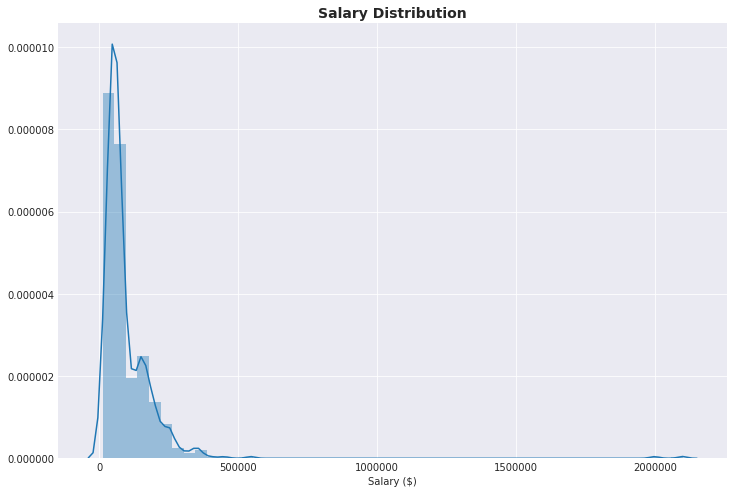

In [50]:
salary_fig, ax = plt.subplots(figsize=(12, 8))
ax = sns.distplot(df2['Salary'], ax=ax)

ax.set_title('Salary Distribution', fontdict={'size': 14, 'weight': 'bold'})
ax.set_xlabel('Salary ($)')

In [51]:
salary_fig.savefig('../figures/SalaryDistribution.svg')

Text(0.5,0,'Log[Salary ($)]')

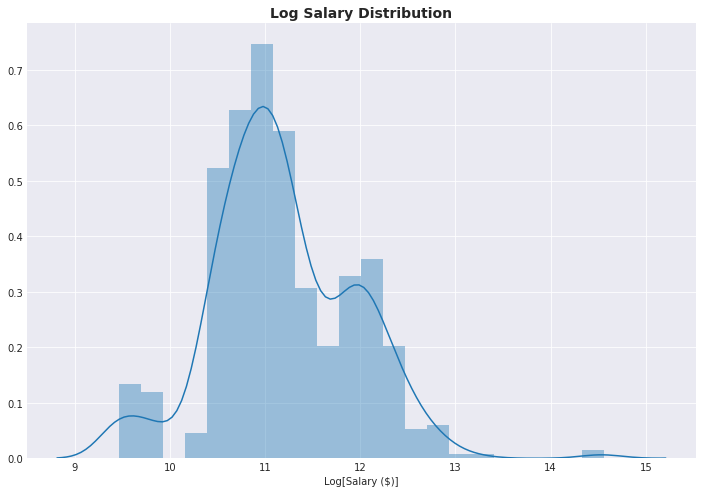

In [52]:
log_salary_fig, ax = plt.subplots(figsize=(12, 8))
ax = sns.distplot(df2['Log_Salary'], ax=ax)

ax.set_title('Log Salary Distribution', fontdict={'size': 14, 'weight': 'bold'})
ax.set_xlabel('Log[Salary ($)]')

In [53]:
log_salary_fig.savefig('../figures/LogSalaryDistribution.svg')

In [78]:
df2.columns

Index(['Player', 'Club', 'POS', 'Salary', 'Log_Salary', 'Year', 'GP', 'GS', 'MINS', 'SHTS', 'SV', 'GA', 'GAA', 'ShO', 'SvPct', 'W', 'L', 'T'], dtype='object')

In [86]:
for ii in range(10, 0, -1):
    print(ii)

10
9
8
7
6
5
4
3
2
1


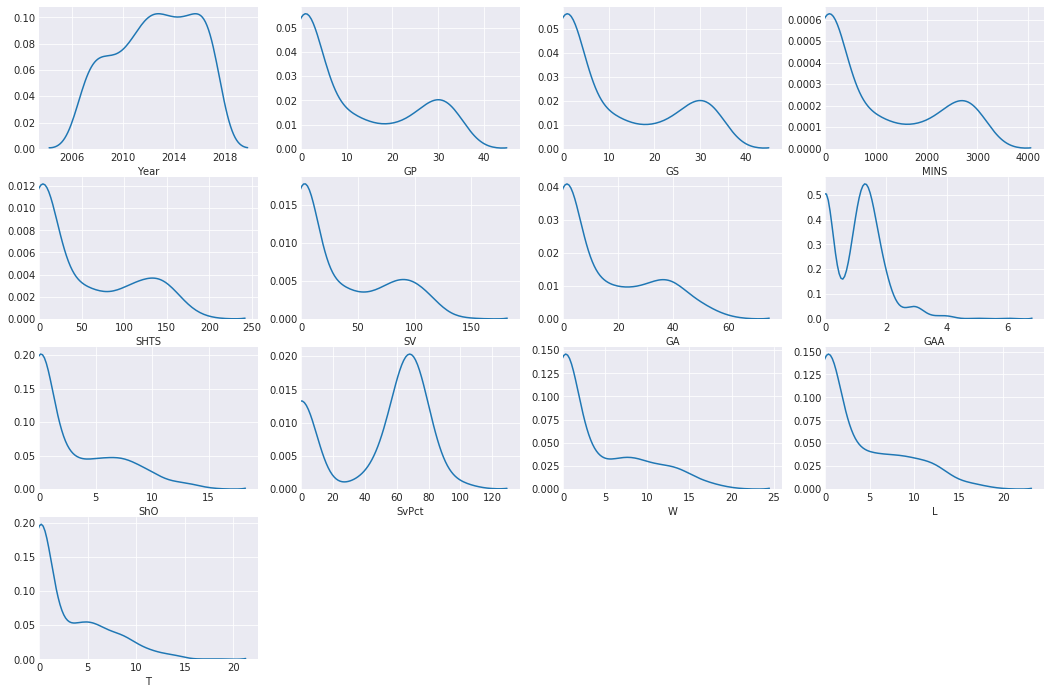

In [97]:
kde_fig, axes = plt.subplots(4, 4, figsize=(18, 12))
axes = axes.flatten()

for ax, col in zip(axes, df2.columns[5:]):
    ax = sns.distplot(df2[col], hist=False, ax=ax)
#     ax.set_xlabel(col, fontdict={'weight': 'bold'})
    if col == 'Year':
        ax.set_xticks([2006, 2010, 2014, 2018])
        ax.set_xticks([2008, 2010, 2012, 2016], minor=True)
    else:
        ax.set_xlim(left=0)
    

axes[-1].remove()
axes[-2].remove()
axes[-3].remove()

In [95]:
kde_fig.savefig('../figures/FeatureDistributions.svg')

In [ ]:
for ax, col in zip(axes[:-2], df2.columns[2:]):
    cnt += 1
    for q in sorted(df.Log_Salary.unique()):
        label = ('quality %d' % q)
        
        ax = sns.distplot(df[col][df.quality == q], hist=False, label=label, ax=ax)
        if cnt != 1:
            ax.legend_.remove()
            
plt.suptitle('Feature Distributions', fontsize=18, fontweight='bold')    

In [22]:
corr2 = df2.corr()

Text(0.5,1,'Correlation Heatmap')

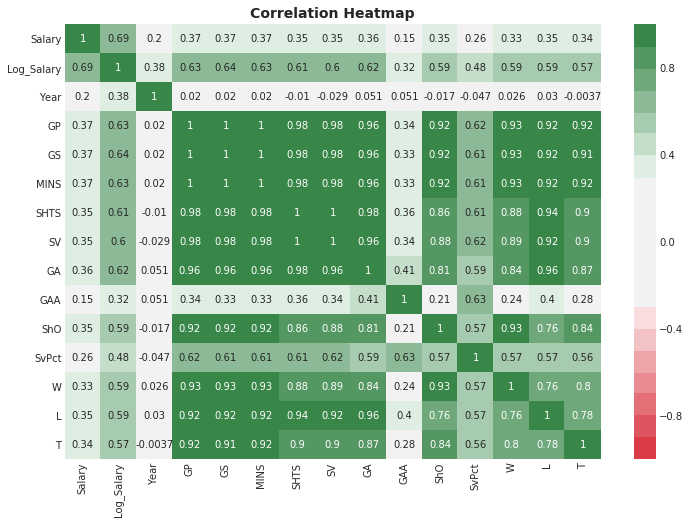

In [44]:
corr_fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(corr2, center=0, vmin=-1, vmax=1,
            cmap=sns.diverging_palette(10, 133, sep=80, n=20),  
            annot=True)
ax.set_title('Correlation Heatmap', fontdict={'size': 14, 'weight': 'bold'})

# plt.title('Correlation Heatmap')

In [45]:
corr_fig.savefig('../figures/FeatureCorrelation.svg')

Text(0.5,0.98,'Feature Relationships')

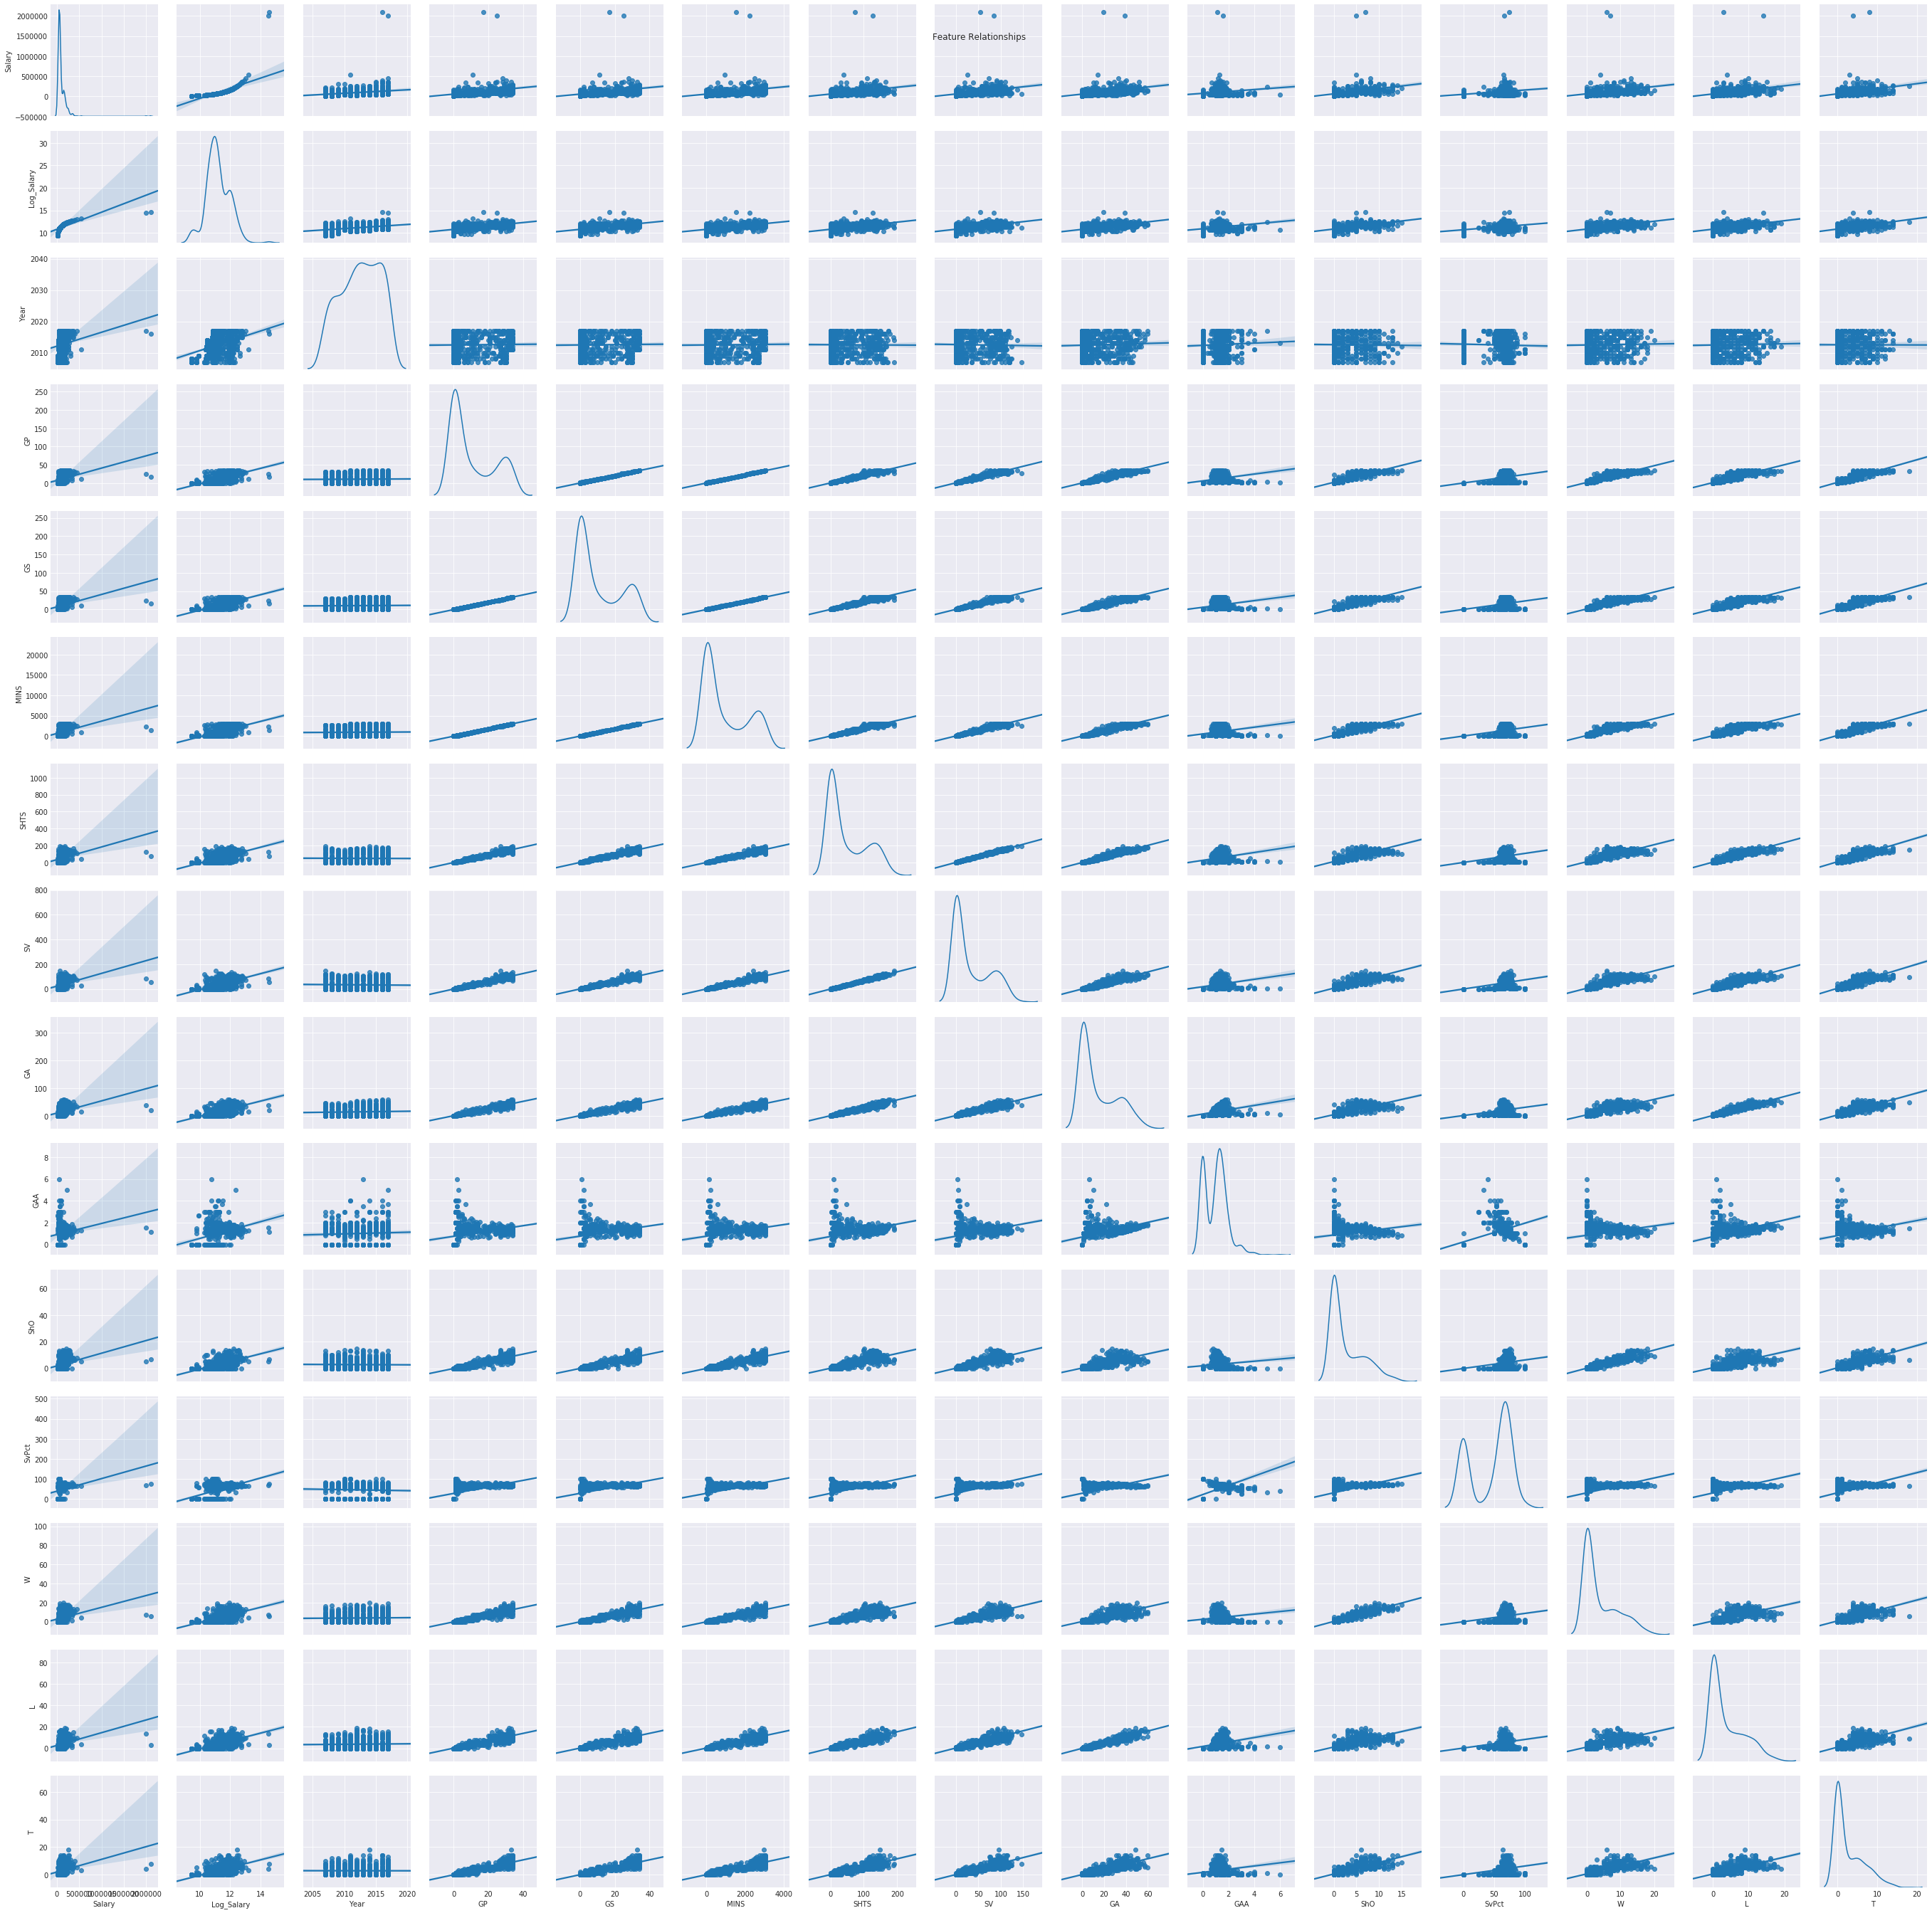

In [60]:
sns.pairplot(df2.iloc[:, 3:], diag_kind="kde", kind='reg')
pair_fig = plt.gcf()

pair_fig.suptitle('Feature Relationships', fontdict={'size': 14, 'weight': 'bold'})

In [61]:
pair_fig.savefig('../figures/FeatureRelationships.svg')

### Statsmodels

In [25]:
# Setup the data
X = df2.iloc[:, 5:]
X['Intercept'] = np.ones((len(X), 1))
y = df2.iloc[:, 4]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=129)

# Create your model
model = sm.OLS(y_train, X_train, hasconst=True)
# Fit your model to your training set
fit = model.fit()
# Print summary statistics of the model's performance
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Log_Salary   R-squared:                       0.590
Model:                            OLS   Adj. R-squared:                  0.576
Method:                 Least Squares   F-statistic:                     43.23
Date:                Sun, 25 Feb 2018   Prob (F-statistic):           1.94e-67
Time:                        18:26:49   Log-Likelihood:                -268.82
No. Observations:                 405   AIC:                             565.6
Df Residuals:                     391   BIC:                             621.7
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Year           0.0847      0.008     10.414      0.000       0.069       0.101
GP            -0.0055      0.084     -0.066      0.948      -0.170       0.159
GS             0.4279      0.100      4.295      0.000       0.232       0.624
MINS          -0.0055      0.002     -2.649      0.008      -0.010      -0.001
SHTS           0.0108      0.017      0.655      0.513      -0.022       0.043
SV            -0.0143      0.017     -0.831      0.406      -0.048       0.019
GA            -0.0168      0.019     -0.862      0.389      -0.055       0.021
GAA            0.0800      0.043      1.852      0.065      -0.005       0.165
ShO            0.0268      0.025      1.056      0.292      -0.023       0.077
SvPct          0.0025      0.001      1.917      0.056   -6.22e-05       0.005
W              0.1032      0.111      0.931      0.352      -0.115       0.321
L              0.1322      0.111      1.192      0.234      -0.086       0.350
T              0.1012      0.112      0.908      0.365      -0.118       0.320
Intercept   -159.8163     16.372     -9.761      0.000    -192.005    -127.628
==============================================================================
Omnibus:                       36.689   Durbin-Watson:                   1.923
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               71.917
Skew:                           0.526   Prob(JB):                     2.42e-16
Kurtosis:                       4.776   Cond. No.                     1.58e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.58e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Text(0.5,1,'Predicted vs. Actual Salary')

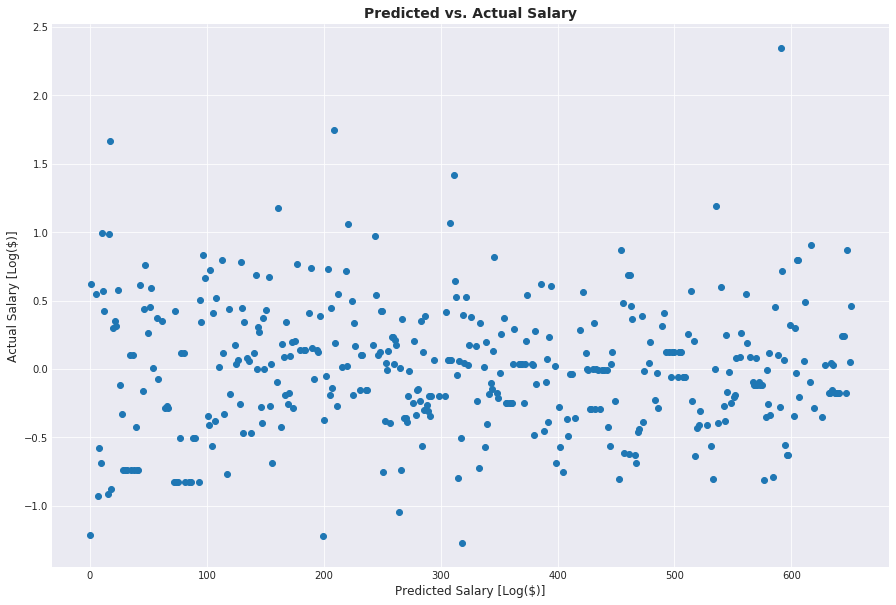

In [66]:
lrfit_fig, ax = plt.subplots(figsize=(15, 10))
fit.resid.plot(ax=ax, style='o')

ax.set_xlabel('Predicted Salary [Log($)]', fontdict={'size': 12})
ax.set_ylabel('Actual Salary [Log($)]', fontdict={'size': 12})
ax.set_title('Predicted vs. Actual Salary', fontdict={'size': 14, 'weight': 'bold'})

In [69]:
lrfit_fig.savefig('../figures/Residuals.svg')

### Sklearn

In [27]:
def rsquared_adj(model, X, y):
    return 1 - (1 - model.score(X, y)) * (len(y) - 1) / (len(y) - X.shape[1] - 1)

In [28]:
r_est = make_pipeline(PolynomialFeatures(1, interaction_only=True), RidgeCV(fit_intercept=True, normalize=True))
r_est.fit(X_train, y_train)
r_est.score(X_test, y_test)
print('rsq:', r_est.score(X_test, y_test), 
      ', rsq_adj:', rsquared_adj(r_est, X_test, y_test))
print('alpha:', r_est.steps[1][1].alpha_)

rsq: 0.537678439643 , rsq_adj: 0.496970880869
alpha: 0.1


In [29]:
l_est = make_pipeline(PolynomialFeatures(1, interaction_only=True), LassoCV(fit_intercept=True, normalize=True))
l_est.fit(X_train, y_train)
l_est.score(X_test, y_test)
print('rsq:', l_est.score(X_test, y_test), 
      ', rsq_adj:', rsquared_adj(l_est, X_test, y_test))
print('alpha:', l_est.steps[1][1].alpha_)

rsq: 0.544762135259 , rsq_adj: 0.504678298112
alpha: 0.000591469671634


/home/cneiderer/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [30]:
e_est = make_pipeline(PolynomialFeatures(1, interaction_only=True), ElasticNetCV(l1_ratio=0.975, fit_intercept=True, normalize=True))
e_est.fit(X_train, y_train)
e_est.score(X_test, y_test)
print('rsq:', e_est.score(X_test, y_test), 
      ', rsq_adj:', rsquared_adj(e_est, X_test, y_test))
print('alpha:', e_est.steps[1][1].alpha_)

rsq: 0.545551133866 , rsq_adj: 0.505536768295
alpha: 0.000372225954891


/home/cneiderer/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [31]:
# Calculate Residuals
yhat = pd.Series(e_est.predict(X), name='Predicted')
residuals = yhat - y

Text(0.5,1,'Predicted vs. Actual Salary')

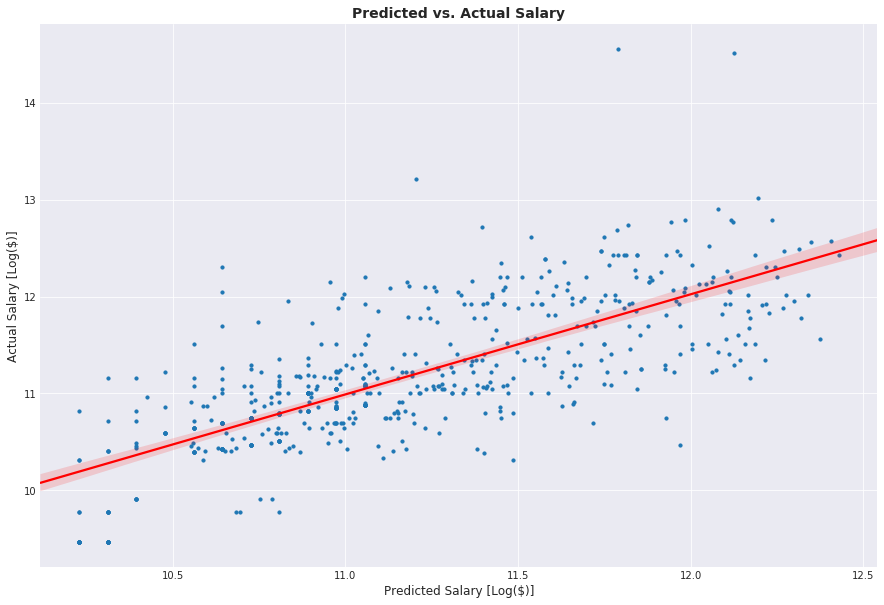

In [63]:
# Plot Fit
sns.set_style('darkgrid')
lrfit_fig, ax = plt.subplots(figsize=(15, 10))

ax = sns.regplot(yhat, y,
                 line_kws={'color':'red'}, 
                 scatter_kws={'alpha':1, 's':10})

ax.set_xlabel('Predicted Salary [Log($)]', fontdict={'size': 12})
ax.set_ylabel('Actual Salary [Log($)]', fontdict={'size': 12})
ax.set_title('Predicted vs. Actual Salary', fontdict={'size': 14, 'weight': 'bold'})

In [64]:
lrfit_fig.savefig('../figures/LinearRegressionFit.svg')

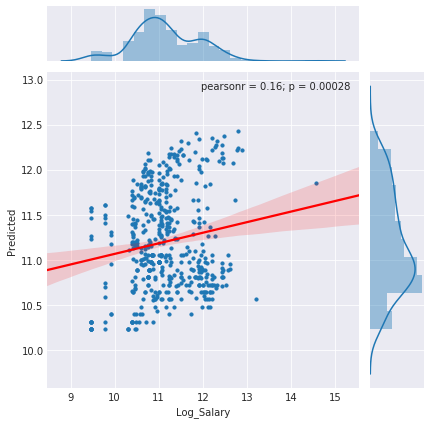

In [33]:
plt.figure(num=None, figsize=(15, 10))
ax = sns.jointplot(y, yhat, kind="reg",
                   line_kws={'color':'red'}, 
                   scatter_kws={'alpha':1, 's':10});


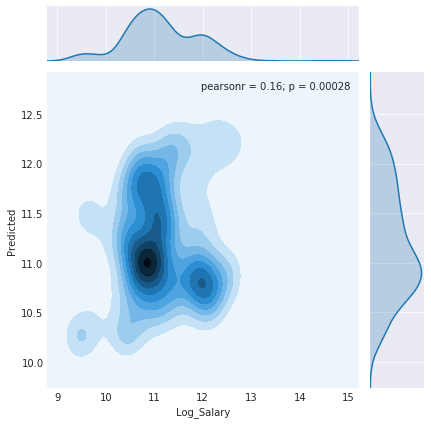

In [34]:
plt.figure(num=None, figsize=(15, 10))
# ax = sns.jointplot(y, yhat, kind='resid',
#                    line_kws={'color':'red'}, 
#                    scatter_kws={'alpha':1, 's':10});
sns.jointplot(y, yhat, kind='kde')


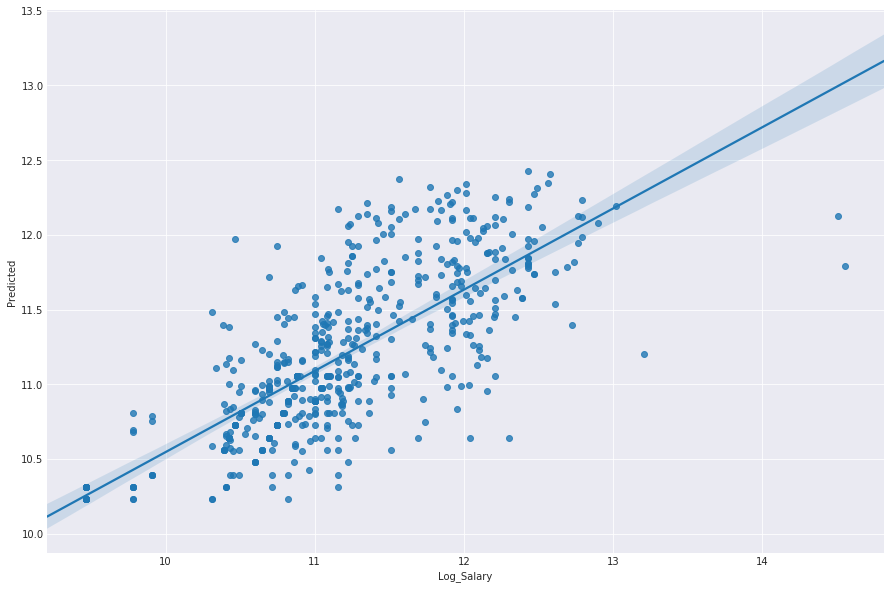

In [39]:
plt.figure(num=None, figsize=(15, 10))
# ax = sns.jointplot(y, yhat, kind='resid',
#                    line_kws={'color':'red'}, 
#                    scatter_kws={'alpha':1, 's':10});
sns.regplot(y, yhat)


In [ ]:
plt.figure(num=None, figsize=(15, 10))
ax = sns.jointplot(y, yhat, kind='resid',
                   line_kws={'color':'red'}, 
                   scatter_kws={'alpha':1, 's':10});
ax.set_axis_labels(ylabel='Residuals', xlabel='Actual Salary [Log($)]')

In [ ]:
np.exp(1)

In [ ]:
# Plot Residuals
plt.figure(num=None, figsize=(15, 10))

idx = np.random.permutation(np.arange(len(residuals)))
idx = np.arange(len(residuals))
ax = plt.scatter(idx, residuals)
plt.title('Prediciton Residuals')

# ax = sns.regplot(random_idx, residuals,
#                  line_kws={'color':'red'}, 
#                  scatter_kws={'alpha':1, 's':10});
# ax.set_ylabel('')
# ax.set_title('Prediction Residuals')

## Log-Log Modeling

In [ ]:
df3 = df[['Player', 'Club', 'POS', 'Salary', 'Log_Salary']]

In [ ]:
for col in df2.columns[5:]:
    df3['Log_' + col] = df[col].map(lambda x: np.log(x+1))

In [ ]:
df3.head()

In [ ]:
df3[df3.isnull().any(axis=1)]

In [ ]:
corr3 = df3.corr()

In [ ]:
plt.figure(num=None, figsize=(15, 10))
sns.heatmap(corr3, center=0, cmap=sns.diverging_palette(10, 220, sep=80, n=20), vmin=-1, vmax=1)
plt.title('Correlation Heatmap')

In [ ]:
plt.figure(num=None)
# sns.pairplot(df3.iloc[:, 3:])
sns.pairplot(df3.iloc[:, 3:], diag_kind="kde", kind='reg')
plt.title('Pairplot Matrix')

### Statsmodels

In [ ]:
# Setup the data
X = df3.iloc[:, 5:]
# X['Intercept'] = np.ones((len(X), 1))
y = df3.iloc[:, 4]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=129)

# Create your model
model = sm.OLS(y_train, X_train, hasconst=True)
# Fit your model to your training set
fit = model.fit()
# Print summary statistics of the model's performance
fit.summary()

### Sklearn

In [ ]:
r_est = make_pipeline(PolynomialFeatures(2, interaction_only=True), RidgeCV(fit_intercept=True, normalize=True))
r_est.fit(X_train, y_train)
r_est.score(X_test, y_test)
print('rsq:', r_est.score(X_test, y_test), ', rsq_adj:', rsquared_adj(r_est, X_test, y_test))

In [ ]:
l_est = make_pipeline(PolynomialFeatures(2, interaction_only=True), LassoCV(fit_intercept=True, normalize=True))
l_est.fit(X_train, y_train)
l_est.score(X_test, y_test)
print('rsq:', l_est.score(X_test, y_test), ', rsq_adj:', rsquared_adj(l_est, X_test, y_test))

In [ ]:
e_est = make_pipeline(PolynomialFeatures(2, interaction_only=True), ElasticNetCV(l1_ratio=0.975, fit_intercept=True, normalize=True))
e_est.fit(X_train, y_train)
e_est.score(X_test, y_test)
print('rsq:', e_est.score(X_test, y_test), ', rsq_adj:', rsquared_adj(e_est, X_test, y_test))

## Combo Modeling

In [ ]:
df4 = df2.merge(df3, on=['Player', 'Club', 'POS', 'Salary', 'Log_Salary'])

### Statsmodels

In [ ]:
# Setup the data
X = df4.iloc[:, 5:]
# X['Intercept'] = np.ones((len(X), 1))
y = df4.iloc[:, 4]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=129)

# Create your model
model = sm.OLS(y_train, X_train, hasconst=True)
# Fit your model to your training set
fit = model.fit()
# Print summary statistics of the model's performance
fit.summary()

### Sklearn

In [ ]:
r_est = make_pipeline(PolynomialFeatures(2, interaction_only=True), RidgeCV(fit_intercept=True, normalize=True))
r_est.fit(X_train, y_train)
r_est.score(X_test, y_test)
print('rsq:', r_est.score(X_test, y_test), ', rsq_adj:', rsquared_adj(r_est, X_test, y_test))

In [ ]:
l_est = make_pipeline(PolynomialFeatures(2, interaction_only=True), LassoCV(fit_intercept=True, normalize=True))
l_est.fit(X_train, y_train)
l_est.score(X_test, y_test)
print('rsq:', l_est.score(X_test, y_test), ', rsq_adj:', rsquared_adj(l_est, X_test, y_test))

In [ ]:
e_est = make_pipeline(PolynomialFeatures(2, interaction_only=True), ElasticNetCV(l1_ratio=0.975, fit_intercept=True, normalize=True))
e_est.fit(X_train, y_train)
e_est.score(X_test, y_test)
print('rsq:', e_est.score(X_test, y_test), ', rsq_adj:', rsquared_adj(e_est, X_test, y_test))

In [ ]:
df.head()

In [ ]:
# Setup the data
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, 5:], df.iloc[:, 0], test_size=0.3, random_state=129)

# Create your model
model = sm.OLS(y_train, X_train)
# Fit your model to your training set
fit = model.fit()
# Print summary statistics of the model's performance
fit.summary()

In [ ]:
# Setup the data
X = df.iloc[:, 5:]
# X['Intercept'] = np.ones((len(X), 1))
y = df.iloc[:, 4]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=129)

# Create your model
model = sm.OLS(y_train, X_train, hasconst=False)
# Fit your model to your training set
fit = model.fit()
# Print summary statistics of the model's performance
fit.summary()

In [ ]:
fit.resid.plot(style='o', figsize=(12,8));

In [ ]:
# Setup the data
X = df3.iloc[:, 5:]
# X = df3.iloc[:, 19:]
# X['Intercept'] = np.ones((len(X), 1))
y = df3.iloc[:, 4]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=129)

# Create your model
model = sm.OLS(y_train, X_train, hasconst=False)
# Fit your model to your training set
fit = model.fit()
# Print summary statistics of the model's performance
fit.summary()

In [ ]:
fit.resid.plot(style='o', figsize=(12,8));

In [ ]:
est = make_pipeline(PolynomialFeatures(2, interaction_only=True), LinearRegression())
est.fit(X_train, y_train)
est.score(X_test, y_test)

In [ ]:
lr = LinearRegression(fit_intercept=False, normalize=False)
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

In [ ]:
lr = RidgeCV(fit_intercept=False, normalize=False)
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

In [ ]:
lr = LassoCV(fit_intercept=False, normalize=False)
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

In [ ]:
lr = ElasticNetCV(l1_ratio=0.025, fit_intercept=False, normalize=False)
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

### Sandbox

In [ ]:
df3.head()

In [ ]:
# # Setup the data
# # X = df3.iloc[:, 5:]
# X = sm.add_constant(df[['GS', 'MINS', 'ShO']])
# # y = df3.iloc[:, 0]
# # y = df3['Salary']
# y = df3['Log_Salary']

# X = df3.iloc[:, 6]
# X = sm.add_constant(df3.iloc[:, 6])

df4 = df3[df3.GP > 0]
X = sm.add_constant(df4.iloc[:, list(np.arange(8,16)) + [17,18]])
y = df4['ShO'] #.map(lambda x: np.log(x+1))

In [ ]:
plt.figure(num=None, figsize=(15, 10))
sns.heatmap(corr3, center=0, cmap=sns.diverging_palette(10, 220, sep=80, n=20), vmin=-1, vmax=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=129)

# Create your model
model = sm.OLS(y_train, X_train, hasconst=True)
# Fit your model to your training set
fit = model.fit()
# Print summary statistics of the model's performance
fit.summary()

In [ ]:
fit.resid.plot(style='o', figsize=(12,8));

In [ ]:
lr = LinearRegression(fit_intercept=True, normalize=True)
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

In [ ]:
lr.score(X_train, y_train)

In [ ]:
lr.coef_

In [ ]:
lr = RidgeCV(fit_intercept=True, normalize=True)
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

In [ ]:
lr.coef_

In [ ]:
lr = LassoCV(fit_intercept=False, normalize=False)
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

In [ ]:
X.columns

In [ ]:
lr.coef_

In [ ]:
lr = ElasticNetCV(l1_ratio=0.95, fit_intercept=False, normalize=False)
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

In [ ]:
yhat = pd.Series(fit.predict(X_test), name='Pred_ShO')

plt.figure(num=None, figsize=(15, 10))
plt.scatter(yhat, y_test)
plt.xlabel('yhat')
plt.ylabel('ytest')

In [ ]:
sns.pairplot(X.join(y), diag_kind="kde", kind='reg')

In [ ]:
g = sns.PairGrid(X.join(y)) 
g.map_upper(sns.regplot) 
g.map_lower(sns.residplot) 
g.map_diag(sns.kdeplot, lw=3, legend=False) 

In [ ]:
plt.figure(num=None, figsize=(15, 10))
sns.regplot(yhat, y_test);

In [ ]:
corr3 = X.join(y).corr()
corr3

In [ ]:
sns.pairplot(X.join(y))

In [ ]:
# 
alphas = np.logspace(-9, 9, num=19)
rscores = np.zeros(len(alphas))
lscores = np.zeros(len(alphas))
escores = np.zeros(len(alphas))
for ii, a in enumerate(alphas):    
    # RidgeCV
    rcv = RidgeCV(cv=10, alphas=[a], fit_intercept=True)
    rcv.fit(X, y)
    rscores[ii] = rcv.score(X, y)
    # LassoCV
    lcv = LassoCV(cv=10, alphas=[a], fit_intercept=True)
    lcv.fit(X, y)
    lscores[ii] = lcv.score(X, y)    
    # ElasticNetCV
    ecv = ElasticNetCV(cv=10, alphas=[a], l1_ratio=0.5, fit_intercept=True)
    ecv.fit(X, y)
    escores[ii] = ecv.score(X, y)

In [ ]:
np.array([alphas, rscores, lscores, escores]).T

In [ ]:
# Plot the alpha vs. scores
plt.figure(figsize=(8,6))
plt.semilogx(alphas, rscores, color='g', label='Ridge')
plt.semilogx(alphas, lscores, color='b', label='Lasso')
plt.semilogx(alphas, escores, color='r', label='ElasticNet')
plt.ylim((0.0, 1e0))
plt.ylabel('R^2')
plt.xlabel('alpha')
plt.title('Regularized Regression Comparsion')
plt.legend(loc='lower left')

In [ ]:
lr = Ridge(alpha=100, fit_intercept=True, normalize=True)
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

In [ ]:
coef = {}
for idx, c in enumerate(X.columns):
    coef[c] = lr.coef_[idx]

In [ ]:
coef

In [ ]:
lr = Lasso(alpha=0.01, fit_intercept=False, normalize=False)
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

In [ ]:
lr = ElasticNet(alpha=0.01, l1_ratio=0.5, fit_intercept=False, normalize=False)
lr.fit(X_train, y_train)
lr.score(X_test, y_test)